<a href="https://colab.research.google.com/github/sauravakolia/VirtualMakeup/blob/main/Makeup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Original Image**

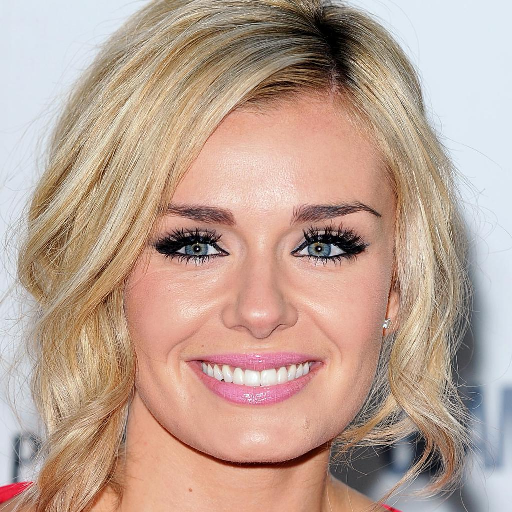

**Virtual Makeup**

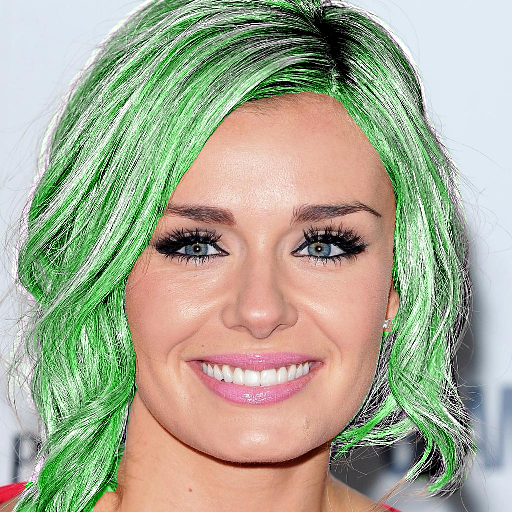

# Downloading and Preprocessing

In [ ]:
!nvidia-smi

In [ ]:
# !wget --header 'Host: doc-08-44-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:85.0) Gecko/20100101 Firefox/85.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/u/0/uc?export=download&confirm=Yo93&id=1badu11NqxGf6qM3PTTooQDJvQbejgbTv' --header 'Cookie: AUTH_bf9cogjcoqvvmjqikslgid7hua5o271b_nonce=b5rhdhad0lljq' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-08-44-docs.googleusercontent.com/docs/securesc/69qu86rakjj8i03u5e8c2fao2nknkovh/7e4piivoof6h8hghkoh6pta31opk4gac/1612419375000/13182073909007362810/03427387775340765805/1badu11NqxGf6qM3PTTooQDJvQbejgbTv?e=download&authuser=0&nonce=b5rhdhad0lljq&user=03427387775340765805&hash=cq1dqncjq9ofr9kk10jv78psn98plh8e' --output-document 'CelebAMask-HQ.zip'

In [ ]:
# downloading the file
!gdown --id 1badu11NqxGf6qM3PTTooQDJvQbejgbTv

In [ ]:
# unzipping the file
!unzip '/content/CelebAMask-HQ.zip'

In [ ]:
import os.path as osp
import os
import cv2
# from transform import *
import numpy as np

from PIL import Image

face_data = '/content/CelebAMask-HQ/CelebA-HQ-img'
face_sep_mask = '/content/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
mask_path = '/content/drive/MyDrive/Celeb/mask'
counter = 0
total = 0

atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
            'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']


In [ ]:

for i in range(15):

    
    for j in range(i * 2000, (i + 1) * 2000):

        mask = np.zeros((512, 512))

        for l, att in enumerate(atts, 1):
            total += 1
            file_name = ''.join([str(j).rjust(5, '0'), '_', att, '.png'])
            path = osp.join(face_sep_mask, str(i), file_name)

            if os.path.exists(path):
                counter += 1
                sep_mask = np.array(Image.open(path).convert('P'))
                # print(np.unique(sep_mask))

                mask[sep_mask == 225] = l
        cv2.imwrite('{}/{}.png'.format(mask_path, j), mask)
        print(j)

print(counter, total)

# Model Functions and Definations

**BISENET ARCHITECTURE**

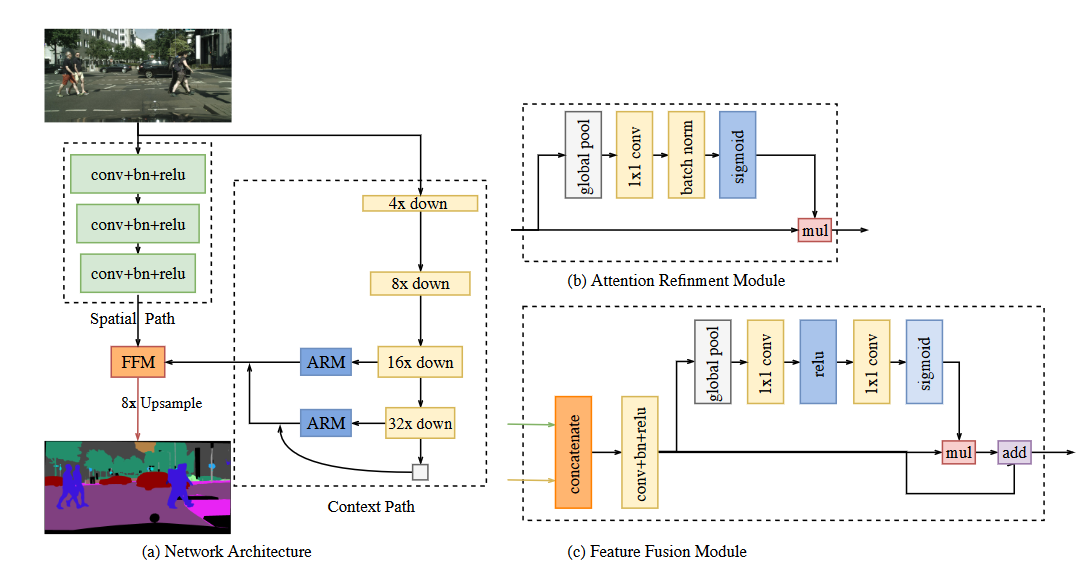

**Transformers**

In [ ]:
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
import random
import numpy as np

class RandomCrop(object):
    def __init__(self, size, *args, **kwargs):
        self.size = size

    def __call__(self, im_lb):
        im = im_lb['im']
        lb = im_lb['lb']
        assert im.size == lb.size
        W, H = self.size
        w, h = im.size

        if (W, H) == (w, h): return dict(im=im, lb=lb)
        if w < W or h < H:
            scale = float(W) / w if w < h else float(H) / h
            w, h = int(scale * w + 1), int(scale * h + 1)
            im = im.resize((w, h), Image.BILINEAR)
            lb = lb.resize((w, h), Image.NEAREST)
        sw, sh = random.random() * (w - W), random.random() * (h - H)
        crop = int(sw), int(sh), int(sw) + W, int(sh) + H
        return dict(
                im = im.crop(crop),
                lb = lb.crop(crop)
                    )


class HorizontalFlip(object):
    def __init__(self, p=0.5, *args, **kwargs):
        self.p = p

    def __call__(self, im_lb):
        if random.random() > self.p:
            return im_lb
        else:
            im = im_lb['im']
            lb = im_lb['lb']

          

            flip_lb = np.array(lb)
            flip_lb[lb == 2] = 3
            flip_lb[lb == 3] = 2
            flip_lb[lb == 4] = 5
            flip_lb[lb == 5] = 4
            flip_lb[lb == 7] = 8
            flip_lb[lb == 8] = 7
            flip_lb = Image.fromarray(flip_lb)
            return dict(im = im.transpose(Image.FLIP_LEFT_RIGHT),
                        lb = flip_lb.transpose(Image.FLIP_LEFT_RIGHT),
                    )


class RandomScale(object):
    def __init__(self, scales=(1, ), *args, **kwargs):
        self.scales = scales

    def __call__(self, im_lb):
        im = im_lb['im']
        lb = im_lb['lb']
        W, H = im.size
        scale = random.choice(self.scales)
        w, h = int(W * scale), int(H * scale)
        return dict(im = im.resize((w, h), Image.BILINEAR),
                    lb = lb.resize((w, h), Image.NEAREST),
                )


class ColorJitter(object):
    def __init__(self, brightness=None, contrast=None, saturation=None, *args, **kwargs):
        if not brightness is None and brightness>0:
            self.brightness = [max(1-brightness, 0), 1+brightness]
        if not contrast is None and contrast>0:
            self.contrast = [max(1-contrast, 0), 1+contrast]
        if not saturation is None and saturation>0:
            self.saturation = [max(1-saturation, 0), 1+saturation]

    def __call__(self, im_lb):
        im = im_lb['im']
        lb = im_lb['lb']
        r_brightness = random.uniform(self.brightness[0], self.brightness[1])
        r_contrast = random.uniform(self.contrast[0], self.contrast[1])
        r_saturation = random.uniform(self.saturation[0], self.saturation[1])
        im = ImageEnhance.Brightness(im).enhance(r_brightness)
        im = ImageEnhance.Contrast(im).enhance(r_contrast)
        im = ImageEnhance.Color(im).enhance(r_saturation)
        return dict(im = im,
                    lb = lb,
                )


class MultiScale(object):
    def __init__(self, scales):
        self.scales = scales

    def __call__(self, img):
        W, H = img.size
        sizes = [(int(W*ratio), int(H*ratio)) for ratio in self.scales]
        imgs = []
        [imgs.append(img.resize(size, Image.BILINEAR)) for size in sizes]
        return imgs


class Compose(object):
    def __init__(self, do_list):
        self.do_list = do_list

    def __call__(self, im_lb):
        for comp in self.do_list:
            im_lb = comp(im_lb)
        return im_lb


**Datasets**

In [ ]:

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os.path as osp
import os
from PIL import Image
import numpy as np
import json
import cv2

class FaceMask(Dataset):
    def __init__(self, rootpth, cropsize=(640, 480), mode='train', *args, **kwargs):
        super(FaceMask, self).__init__(*args, **kwargs)
        assert mode in ('train', 'val', 'test')
        self.mode = mode
        self.ignore_lb = 255
        self.rootpth = rootpth

        self.imgs = os.listdir(os.path.join(self.rootpth, 'CelebA-HQ-img'))

        #  pre-processing
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        self.trans_train = Compose([
            ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5),
            HorizontalFlip(),
            RandomScale((0.75, 1.0, 1.25, 1.5, 1.75, 2.0)),
            RandomCrop(cropsize)
            ])

    def __getitem__(self, idx):
        impth = self.imgs[idx]
        img = Image.open(osp.join(self.rootpth, 'CelebA-HQ-img', impth))
        img = img.resize((512, 512), Image.BILINEAR)
        label = Image.open(osp.join('/content/drive/MyDrive/Celeb/mask', impth[:-3]+'png')).convert('P')
        # print(np.unique(np.array(label)))
        if self.mode == 'train':
            im_lb = dict(im=img, lb=label)
            im_lb = self.trans_train(im_lb)
            img, label = im_lb['im'], im_lb['lb']
        img = self.to_tensor(img)
        label = np.array(label).astype(np.int64)[np.newaxis, :]
        return img, label

    def __len__(self):
        return len(self.imgs)

**Loss Function**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


class OhemCELoss(nn.Module):
    def __init__(self, thresh, n_min, ignore_lb=255, *args, **kwargs):
        super(OhemCELoss, self).__init__()
        self.thresh = -torch.log(torch.tensor(thresh, dtype=torch.float)).cuda()
        self.n_min = n_min
        self.ignore_lb = ignore_lb
        self.criteria = nn.CrossEntropyLoss(ignore_index=ignore_lb, reduction='none')

    def forward(self, logits, labels):
        N, C, H, W = logits.size()
        loss = self.criteria(logits, labels).view(-1)
        loss, _ = torch.sort(loss, descending=True)
        if loss[self.n_min] > self.thresh:
            loss = loss[loss>self.thresh]
        else:
            loss = loss[:self.n_min]
        return torch.mean(loss)


class SoftmaxFocalLoss(nn.Module):
    def __init__(self, gamma, ignore_lb=255, *args, **kwargs):
        super(SoftmaxFocalLoss, self).__init__()
        self.gamma = gamma
        self.nll = nn.NLLLoss(ignore_index=ignore_lb)

    def forward(self, logits, labels):
        scores = F.softmax(logits, dim=1)
        factor = torch.pow(1.-scores, self.gamma)
        log_score = F.log_softmax(logits, dim=1)
        log_score = factor * log_score
        loss = self.nll(log_score, labels)
        return loss


**Optimizer**

In [ ]:

class Optimizer(object):
    def __init__(self,
                model,
                lr0,
                momentum,
                wd,
                warmup_steps,
                warmup_start_lr,
                max_iter,
                power,
                *args, **kwargs):
        self.warmup_steps = warmup_steps
        self.warmup_start_lr = warmup_start_lr
        self.lr0 = lr0
        self.lr = self.lr0
        self.max_iter = float(max_iter)
        self.power = power
        self.it = 0
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = model.get_params()
        param_list = [
                {'params': wd_params},
                {'params': nowd_params, 'weight_decay': 0},
                {'params': lr_mul_wd_params, 'lr_mul': True},
                {'params': lr_mul_nowd_params, 'weight_decay': 0, 'lr_mul': True}]
        self.optim = torch.optim.SGD(
                param_list,
                lr = lr0,
                momentum = momentum,
                weight_decay = wd)
        self.warmup_factor = (self.lr0/self.warmup_start_lr)**(1./self.warmup_steps)


    def get_lr(self):
        if self.it <= self.warmup_steps:
            lr = self.warmup_start_lr*(self.warmup_factor**self.it)
        else:
            factor = (1-(self.it-self.warmup_steps)/(self.max_iter-self.warmup_steps))**self.power
            lr = self.lr0 * factor
        return lr


    def step(self):
        self.lr = self.get_lr()
        for pg in self.optim.param_groups:
            if pg.get('lr_mul', False):
                pg['lr'] = self.lr * 10
            else:
                pg['lr'] = self.lr
        if self.optim.defaults.get('lr_mul', False):
            self.optim.defaults['lr'] = self.lr * 10
        else:
            self.optim.defaults['lr'] = self.lr
        self.it += 1
        self.optim.step()
        

    def zero_grad(self):
        self.optim.zero_grad()

**Model Architecture**

In [ ]:
# Resnet Architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as modelzoo


resnet18_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_chan, out_chan,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_chan),
                )

    def forward(self, x):
        residual = self.conv1(x)
        residual = F.relu(self.bn1(residual))
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    layers = [BasicBlock(in_chan, out_chan, stride=stride)]
    for i in range(bnum-1):
        layers.append(BasicBlock(out_chan, out_chan, stride=1))
    return nn.Sequential(*layers)


class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)
        self.init_weight()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        feat8 = self.layer2(x) # 1/8
        feat16 = self.layer3(feat8) # 1/16
        feat32 = self.layer4(feat16) # 1/32
        return feat8, feat16, feat32

    def init_weight(self):
        state_dict = modelzoo.load_url(resnet18_url)
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            if 'fc' in k: continue
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module,  nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


In [ ]:
# Bisenet Architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision



class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                out_chan,
                kernel_size = ks,
                stride = stride,
                padding = padding,
                bias = False)
        self.bn = nn.BatchNorm2d(out_chan)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.bn(x))
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(mid_chan, n_classes, kernel_size=1, bias=False)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(out_chan, out_chan, kernel_size= 1, bias=False)
        self.bn_atten = nn.BatchNorm2d(out_chan)
        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class ContextPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        self.resnet = Resnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)

        self.init_weight()

    def forward(self, x):
        H0, W0 = x.size()[2:]
        feat8, feat16, feat32 = self.resnet(x)
        H8, W8 = feat8.size()[2:]
        H16, W16 = feat16.size()[2:]
        H32, W32 = feat32.size()[2:]

        avg = F.avg_pool2d(feat32, feat32.size()[2:])
        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (H32, W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (H16, W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (H8, W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat8, feat16_up, feat32_up  # x8, x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class SpatialPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(SpatialPath, self).__init__()
        self.conv1 = ConvBNReLU(3, 64, ks=7, stride=2, padding=3)
        self.conv2 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv3 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv_out = ConvBNReLU(64, 128, ks=1, stride=1, padding=0)
        self.init_weight()

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = self.conv_out(feat)
        return feat

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                out_chan//4,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.conv2 = nn.Conv2d(out_chan//4,
                out_chan,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class BiSeNet(nn.Module):
    def __init__(self, n_classes, *args, **kwargs):
        super(BiSeNet, self).__init__()
        self.cp = ContextPath()
        ## here self.sp is deleted
        self.ffm = FeatureFusionModule(256, 256)
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)
        self.init_weight()

    def forward(self, x):
        H, W = x.size()[2:]
        feat_res8, feat_cp8, feat_cp16 = self.cp(x)  # here return res3b1 feature
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm(feat_sp, feat_cp8)

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)
        feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)
        feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)
        return feat_out, feat_out16, feat_out32

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, FeatureFusionModule) or isinstance(child, BiSeNetOutput):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params


# **Model Training**

In [ ]:
# dataset
n_classes = 19
n_img_per_gpu = 32
n_workers = 8
cropsize = [448, 448]
data_root = '/content/CelebAMask-HQ'

ds = FaceMask(data_root, cropsize=cropsize, mode='train')

In [ ]:
# Dataloader
from torch.utils.data import DataLoader

dl = DataLoader(ds,
                    batch_size = n_img_per_gpu,
                    shuffle = False,
              
                    num_workers = n_workers,
                    pin_memory = True,
                    drop_last = True)

In [ ]:
# model
ignore_idx = -100
net = BiSeNet(n_classes=n_classes)
net.cuda()

In [ ]:
# net=torch.load("/content/drive/MyDrive/Celeb/79999_iter.pth")
net.load_state_dict(torch.load("/content/drive/MyDrive/Celeb/79999_iter.pth"))

<All keys matched successfully>

In [ ]:
# Loss 
score_thres = 0.7
n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16
LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)

In [ ]:
## optimizer
momentum = 0.9
weight_decay = 5e-4
lr_start = 1e-2
max_iter = 80000
power = 0.9
warmup_steps = 1000
warmup_start_lr = 1e-5
optim = Optimizer(
        model = net,
        lr0 = lr_start,
        momentum = momentum,
        wd = weight_decay,
        warmup_steps = warmup_steps,
        warmup_start_lr = warmup_start_lr,
        max_iter = max_iter,
        power = power)

In [ ]:
from tqdm import trange, tqdm

In [ ]:
# Model Training
msg_iter = 50
loss_avg = []
epochs=100
net.train()
for epoch in range(20,epochs):
  
  bar =tqdm(dl)

  num_samples=0
  running_loss = 0.0
  for batch in bar:
    im, lb = batch
    im = im.cuda()
    lb = lb.cuda()
    H, W = im.size()[2:]
    lb = torch.squeeze(lb, 1)

    optim.zero_grad()
    out, out16, out32 = net(im)
    lossp = LossP(out, lb)
    loss2 = Loss2(out16, lb)
    loss3 = Loss3(out32, lb)
    loss = lossp + loss2 + loss3
    loss.backward()
    optim.step()

    running_loss+=loss.item()*im.size(0)

    num_samples += im.size(0)

    bar.set_postfix(epoch=f'{epoch}' ,loss=f'{running_loss / num_samples:0.1f}')
  
  if(epoch%10==0):
    k=f'{epoch}_epoch.pth'
    path=os.path.join("/content/drive/MyDrive/Celeb",k)
    # path=os.path.join("/content/drive/MyDrive/Celeb",f'{}.pth'.format(epoch))
    torch.save(net,path)


In [ ]:
# path="/content/drive/MyDrive/Celeb"+f'{42}_epoch.pth'
# torch.save(net,"/content/drive/MyDrive/Celeb/42_epoch.pth")
net=torch.load("/content/drive/MyDrive/Celeb/40_epoch.pth")

# Model Evaluation

In [ ]:
def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='/content/parsing_map_on_im2.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])


In [ ]:
 to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
net.eval()
img = Image.open( "/content/CelebAMask-HQ/CelebA-HQ-img/500.jpg")
image = img.resize((512, 512), Image.BILINEAR)

img = to_tensor(image)
img = torch.unsqueeze(img, 0)
print(img.shape)
img = img.cuda()
out = net(img)[0]

torch.Size([1, 3, 512, 512])


In [ ]:
parsing = out.squeeze(0).cpu().detach().numpy().argmax(0)
vis_parsing_maps(image, parsing, stride=1, save_im=True)

In [ ]:
import cv2
import os
import numpy as np
from skimage.filters import gaussian


def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, multichannel=True)

    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img

    img_out = img_out / 255.0

    mask_1 = img_out < 0
    mask_2 = img_out > 1

    img_out = img_out * (1 - mask_1)
    img_out = img_out * (1 - mask_2) + mask_2
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)

def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color      #[10, 50, 250]       # [10, 250, 10]
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    tar_hsv = cv2.cvtColor(tar_color, cv2.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

    if part == 17:
        changed = sharpen(changed)

    changed[parsing != part] = image[parsing != part]
    # changed = cv2.resize(changed, (512, 512))
    return changed



In [ ]:
num = 116
table = {
        'hair': 17,
        'upper_lip': 12,
        'lower_lip': 13
    }

In [ ]:
image_path = '/content/CelebAMask-HQ/CelebA-HQ-img/500.jpg'
parsing_path = '/content/parsing_map_on_im2.png'
image = cv2.imread(image_path)
# image = cv2.resize((512, 512), Image.BILINEAR)
image=cv2.resize(image, (512, 512),  
               interpolation = cv2.INTER_NEAREST) 
ori = image.copy()
parsing = np.array(cv2.imread(parsing_path, 0))
parsing = cv2.resize(parsing, image.shape[0:2], interpolation=cv2.INTER_NEAREST)

parts = [table['hair'], table['upper_lip'], table['lower_lip']]
# colors = [[20, 20, 200], [100, 100, 230], [100, 100, 230]]
colors = [[100, 200, 100]]
# for part, color in zip(parts, colors):
    # image = hair(image, parsing, part, color)
image = hair(image, parsing, part, color)

cv2.imwrite('/content/1161_ori.png', cv2.resize(ori, (512, 512)))
cv2.imwrite('/content/1161_2.png', cv2.resize(image, (512, 512)))

True